# Water Change

## This notebook is currently under development!



### Install requirements

In [1]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

### Import required modules

In [2]:
%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datacube.storage import masking
#from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic, create_mean_mosaic
from datacube_utilities.createAOI import create_lat_lon
#from datacube_utilities.clean_mask import landsat_qa_clean_mask
#from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.dc_utilities import write_geotiff_from_xr

import numpy as np
import xarray as xr
import dask

## Initialise

In [3]:
dc = datacube.Datacube(app='ls8-fcscene')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [52]:
#set baseline start and end of period
baseline_start_date = '2019-1-1'
baseline_end_date = '2019-3-30'

analysis_start_date = '2000-1-1'
analysis_end_date = '2000-8-30'

#resolution - have this as a variable which can be changed. 
res = (30)

# options include "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4", "SENTINEL_2"
analysis_platform = "LANDSAT_7"
baseline_platform = "LANDSAT_8"

aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"

#this is a constant across FIJI so maybe put it not as a variable but built into query. 
output_projection = "EPSG:32760"

## Translate inputs

In [53]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)


In [54]:
#create resolution
resolution = (-res, res)

In [55]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [56]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [57]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [58]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        #water_product = 's2_esa_sr_granule'
        #measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
        print('Sentinel-2 is the platform')
    elif platform in ["LANDSAT_8"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return water_product

In [59]:
baseline_water_product = create_product_measurement(baseline_platform)
analysis_water_product = create_product_measurement(analysis_platform)

## Load Data 

In [60]:
query = {
    'longitude': lon_extents,
    'latitude': lat_extents,
    'output_crs': output_projection,
    'resolution': resolution,
    #'time': baseline_time_period,
    'measurements': water_measurements,
    'dask_chunks': dask_chunks
}

In [61]:
ds_baseline = dc.load(
    platform = baseline_platform,
    product = baseline_water_product,
    time = baseline_time_period,
    **query
)

In [62]:
ds_analysis = dc.load(
    platform = analysis_platform,
    product = analysis_water_product,
    #measurements = measurement,
    time = analysis_time_period,
    **query
)

In [63]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds_baseline): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")
if is_dataset_empty(ds_analysis): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")


In [64]:
#create per scene cloud mask
#cloud_mask = landsat_qa_clean_mask(ds, platform)
#clearsky_scenes = ds.where(cloud_mask)

## Load Water Masks

In [65]:
#water_classes.isel(time = 4).water_classification.plot();
wc_baseline = ds_baseline.where(ds_baseline >= 0)

In [66]:
wc_analysis = ds_analysis.where(ds_analysis >= 0)

## Mask cloud

## Create mosaic of water mask

In [67]:
#create mosaic of water mask
wc_baseline_mean = wc_baseline.water_classification.mean(dim='time')

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


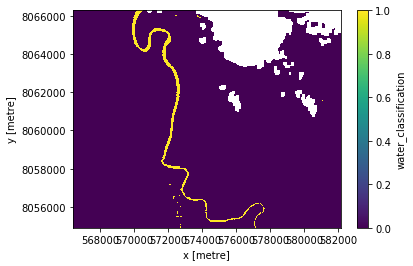

In [86]:
wc_baseline.water_classification.mean(dim = 'time').plot();

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


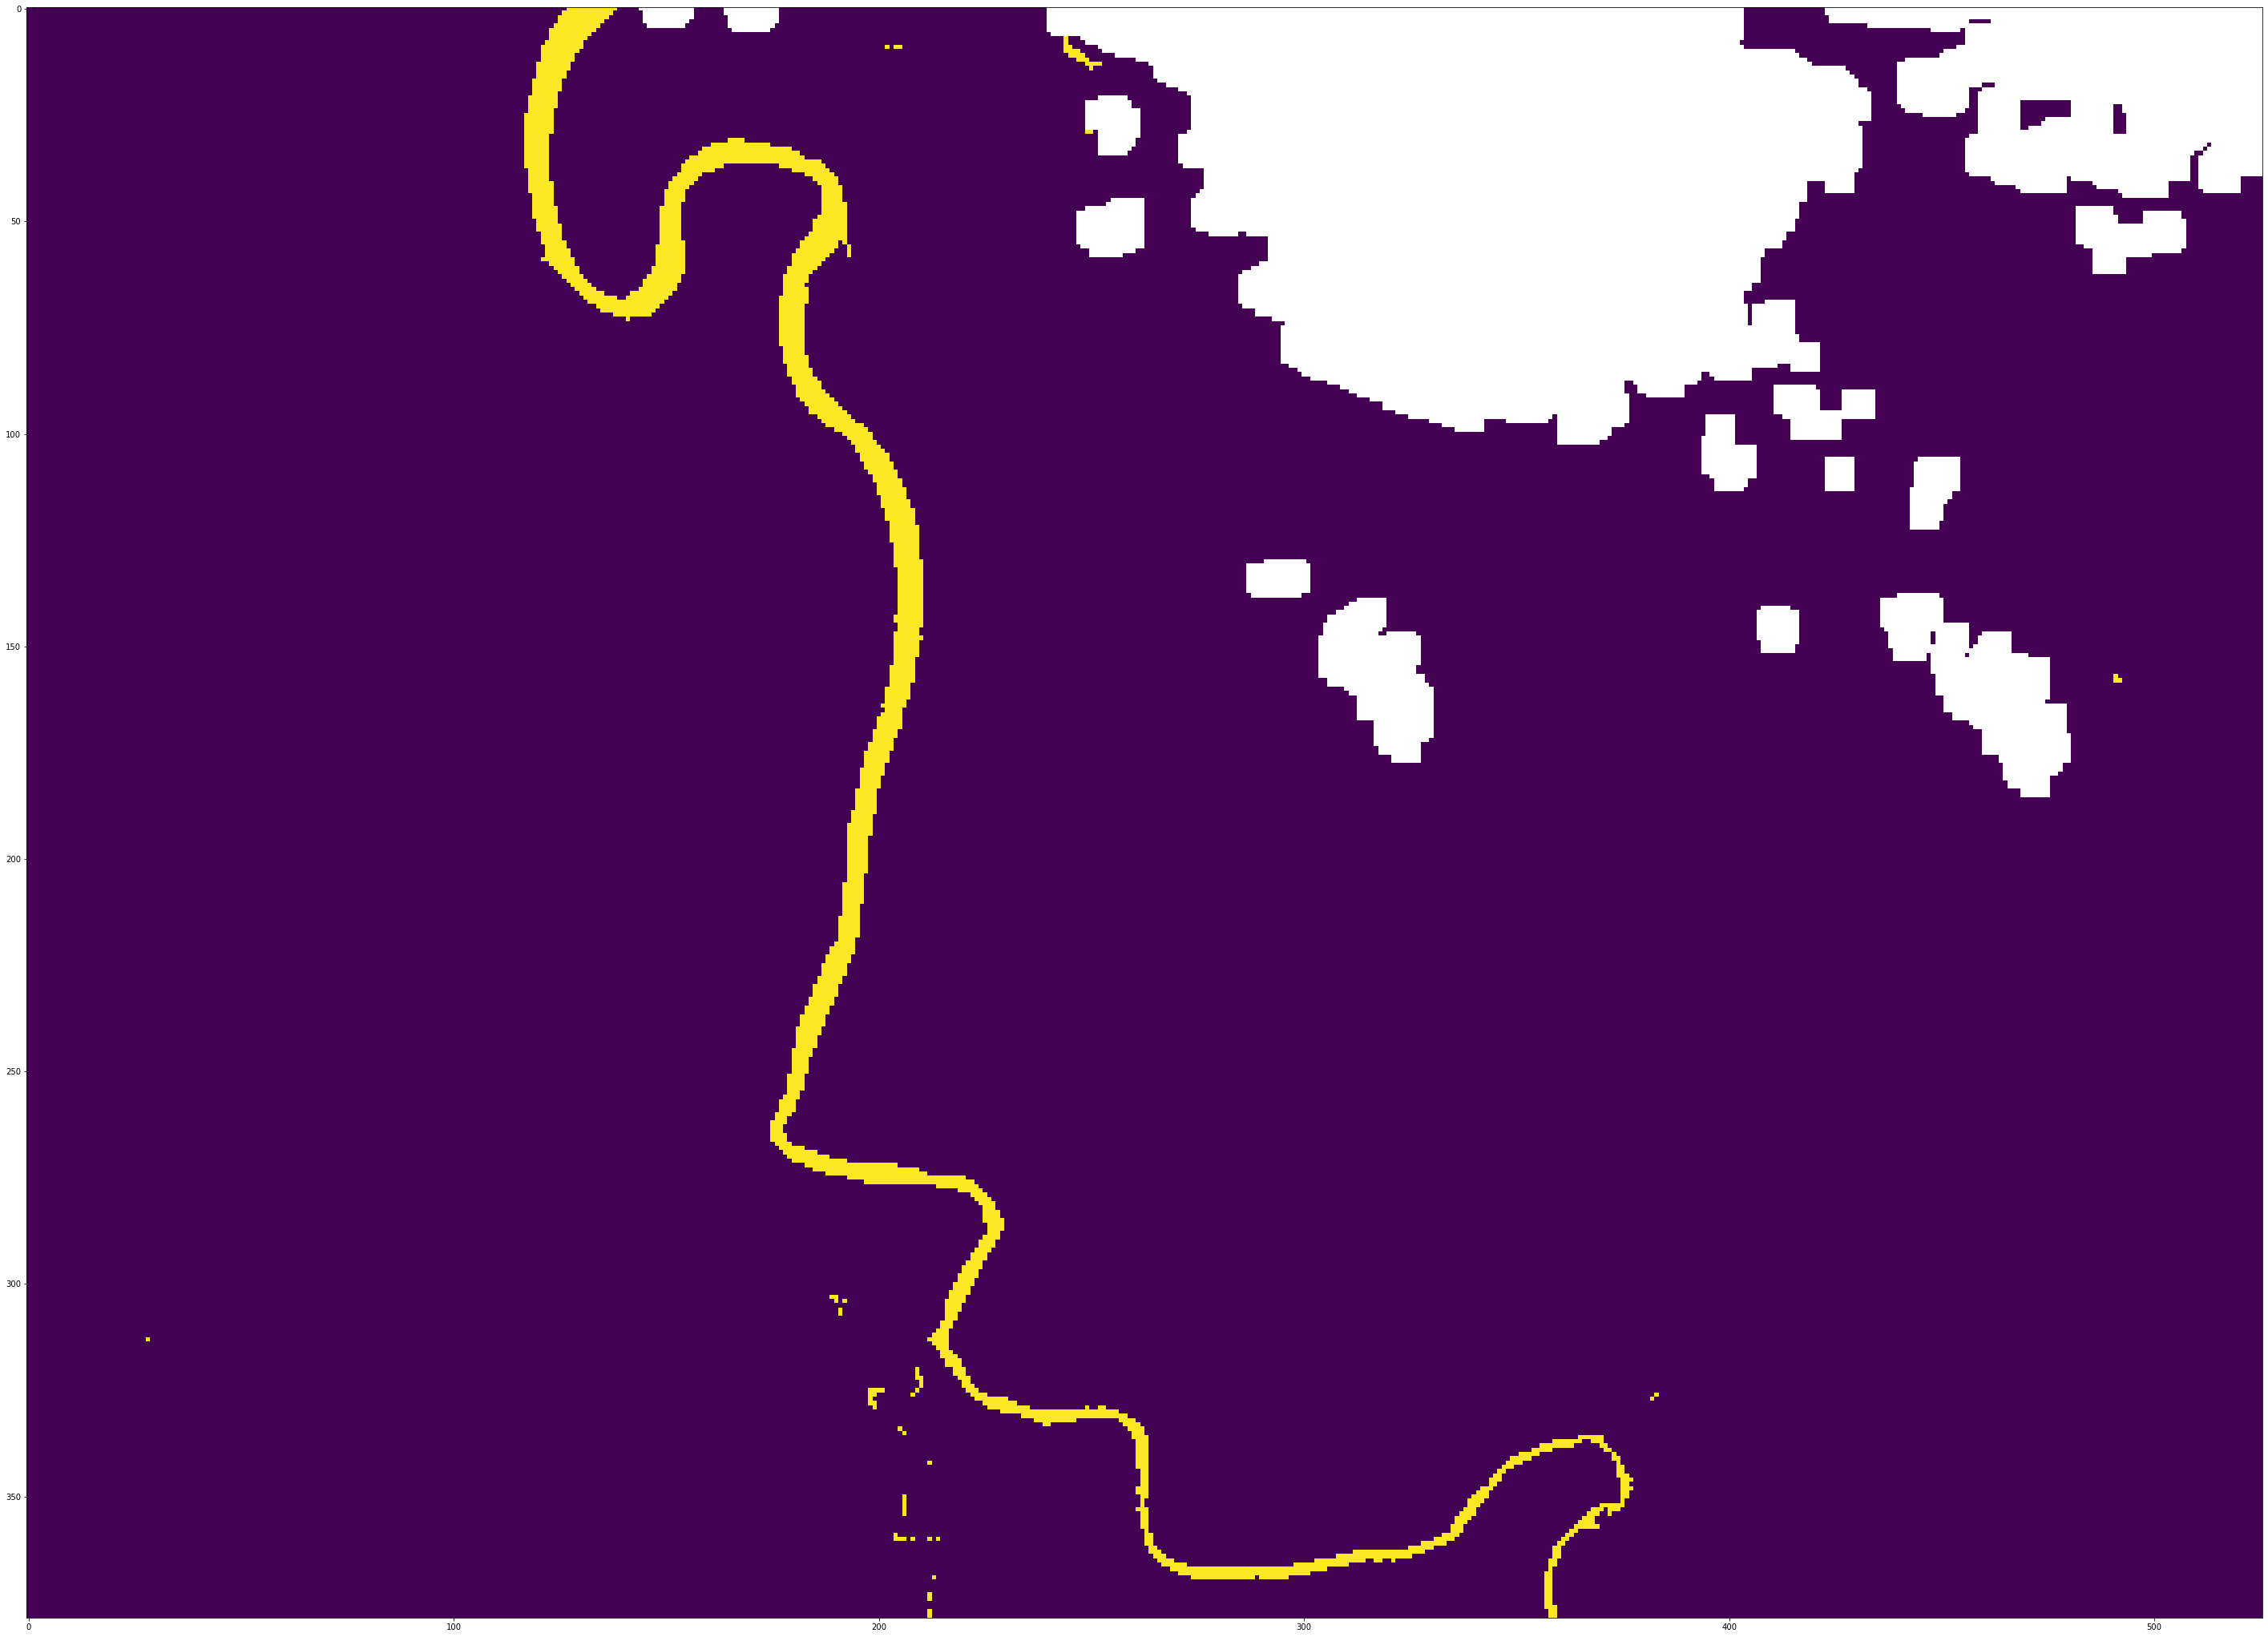

In [82]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_baseline_mean)

In [83]:
wc_analysis_mean = wc_analysis.water_classification.mean(dim='time')
ax.imshow(wc_analysis_mean)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [69]:
%%time
waterpres_prob = 0.3
T0_nd_water = np.isnan(wc_baseline_mean)
wc_baseline_rc_int = wc_baseline_mean.where((wc_baseline_mean < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
wc_baseline_rc = wc_baseline_rc_int.where((wc_baseline_rc_int >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water

CPU times: user 34.6 ms, sys: 381 µs, total: 35 ms
Wall time: 33.2 ms


In [70]:
%%time
T1_nd_water = np.isnan(wc_analysis_mean)
wc_analysis_rc_int = wc_analysis_mean.where((wc_analysis_mean < waterpres_prob) | (T1_nd_water == True), 1) # fix > prob to water
wc_analysis_rc = wc_analysis_rc_int.where((wc_analysis_rc_int >= waterpres_prob) | (T1_nd_water == True), 0) # fix < prob to no water

CPU times: user 34.2 ms, sys: 0 ns, total: 34.2 ms
Wall time: 32.3 ms


/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


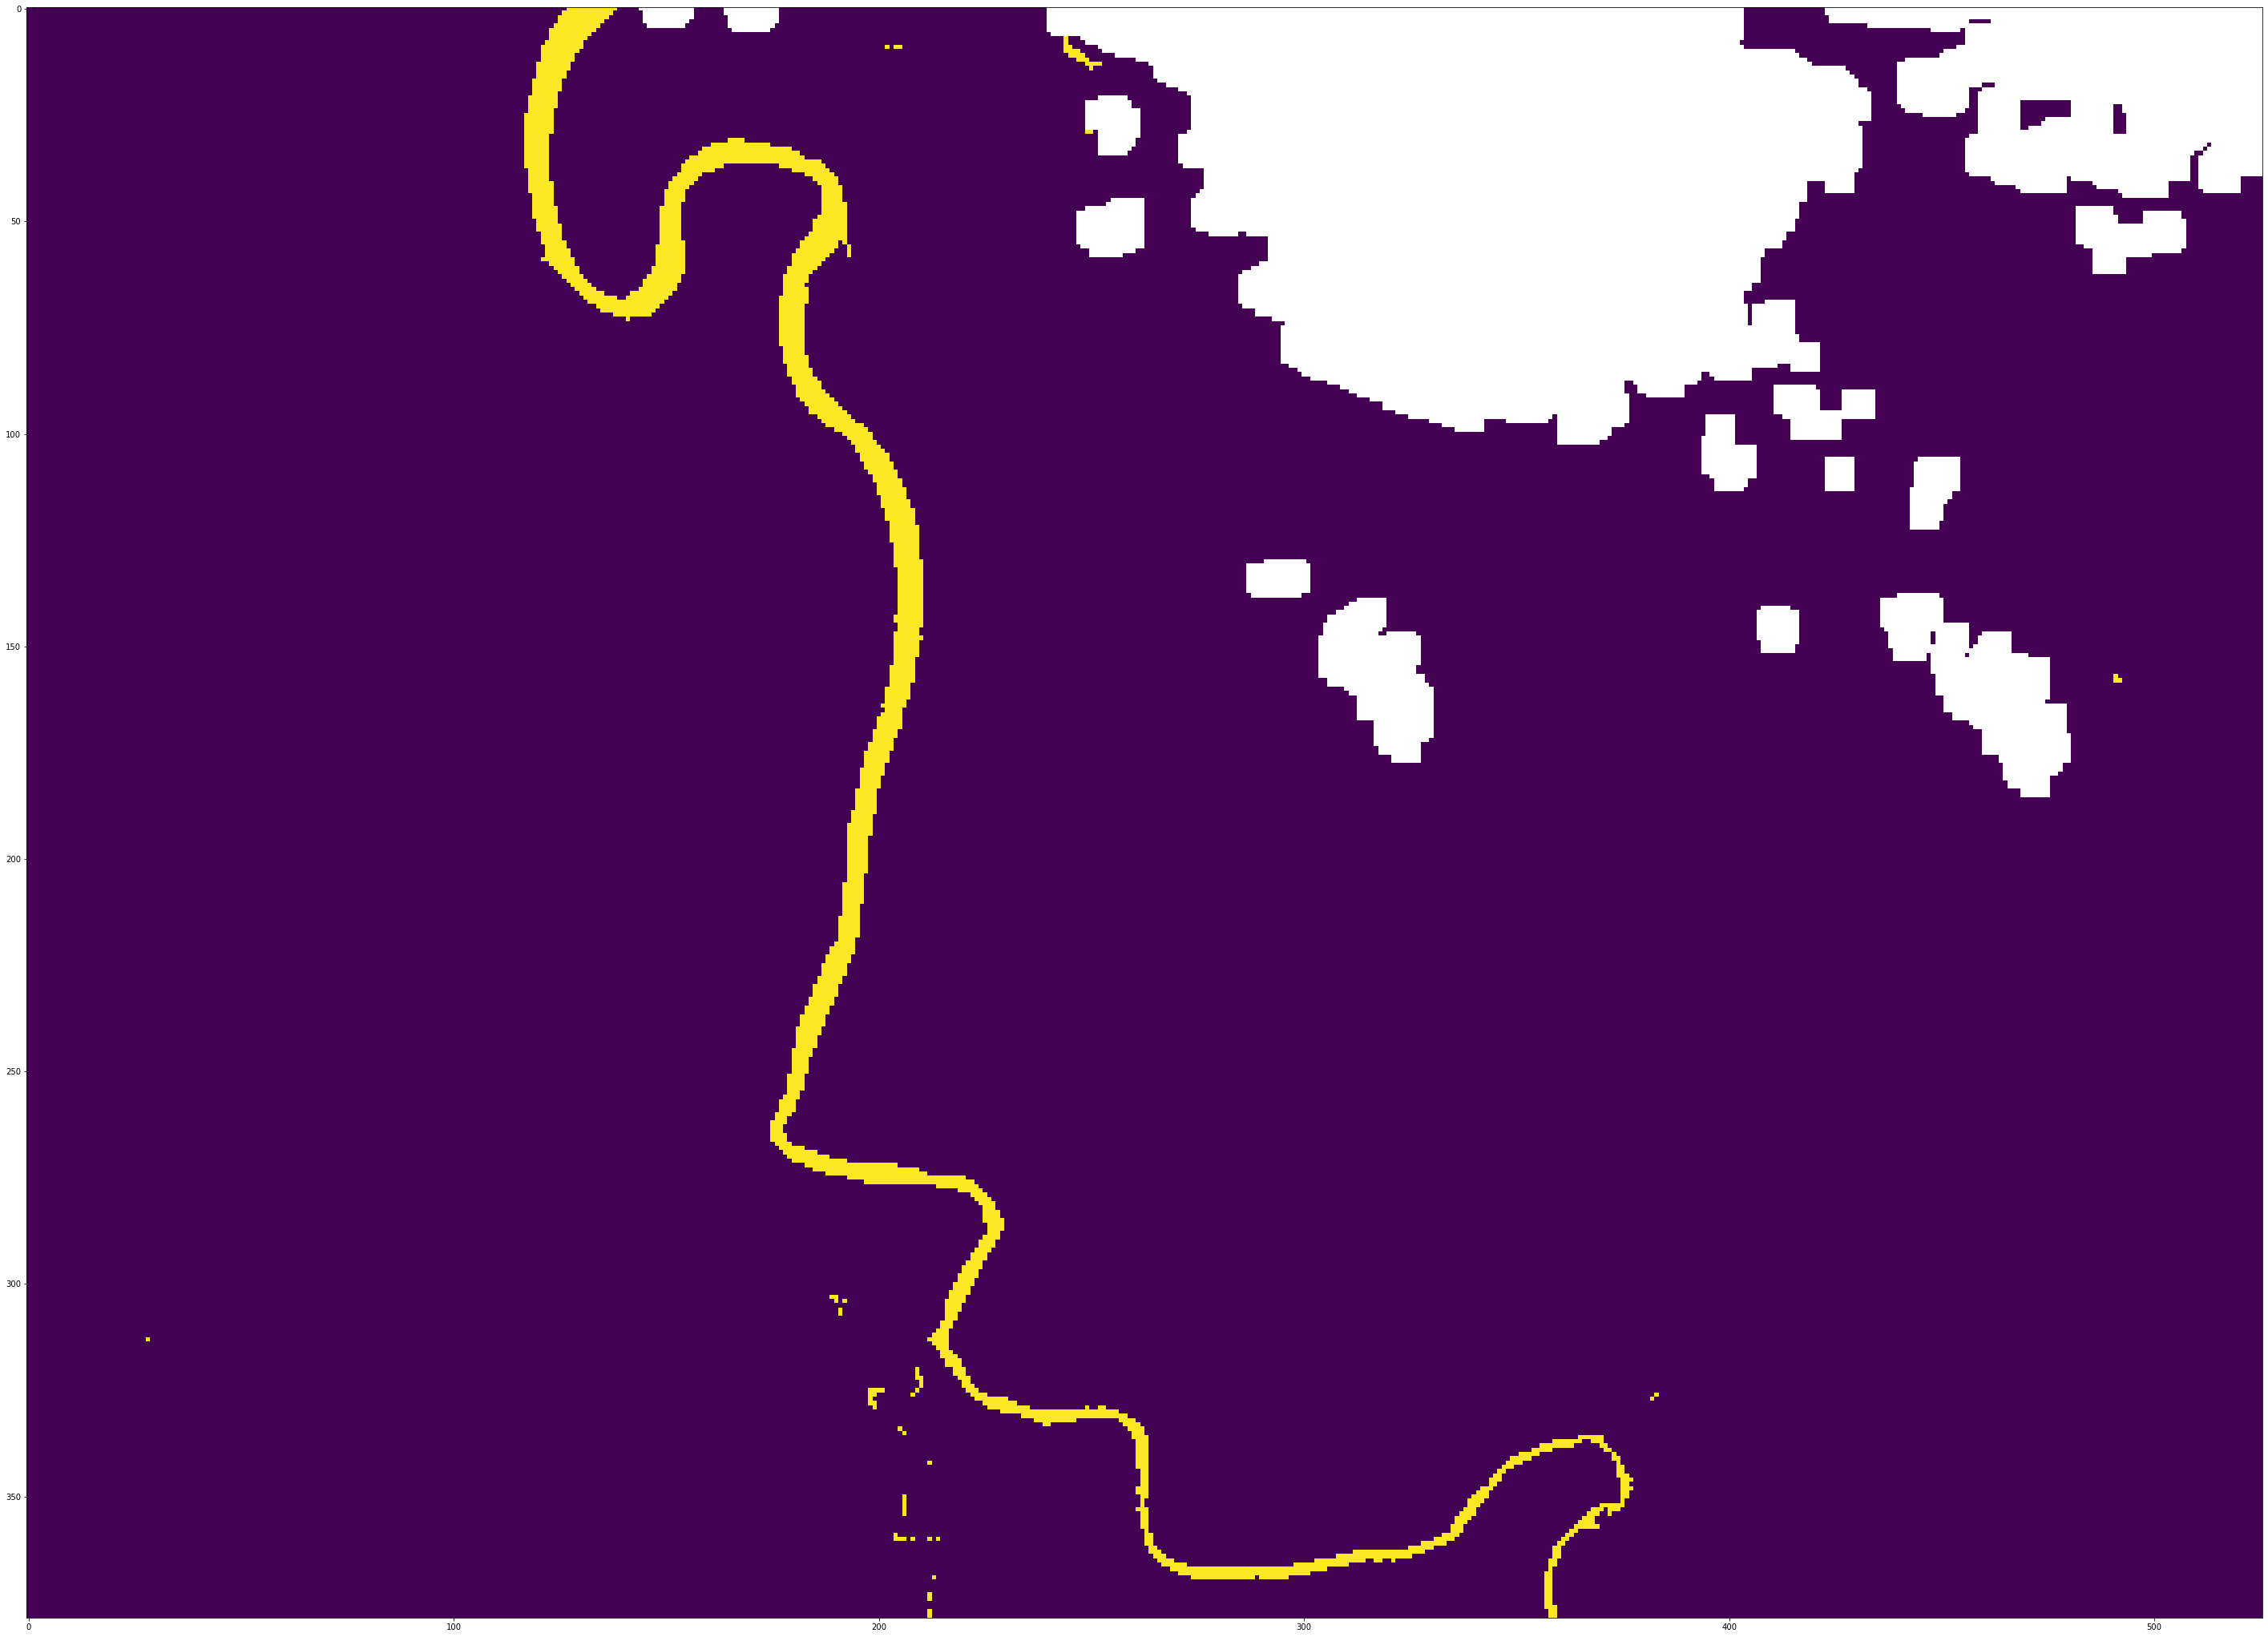

In [71]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_baseline_rc)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


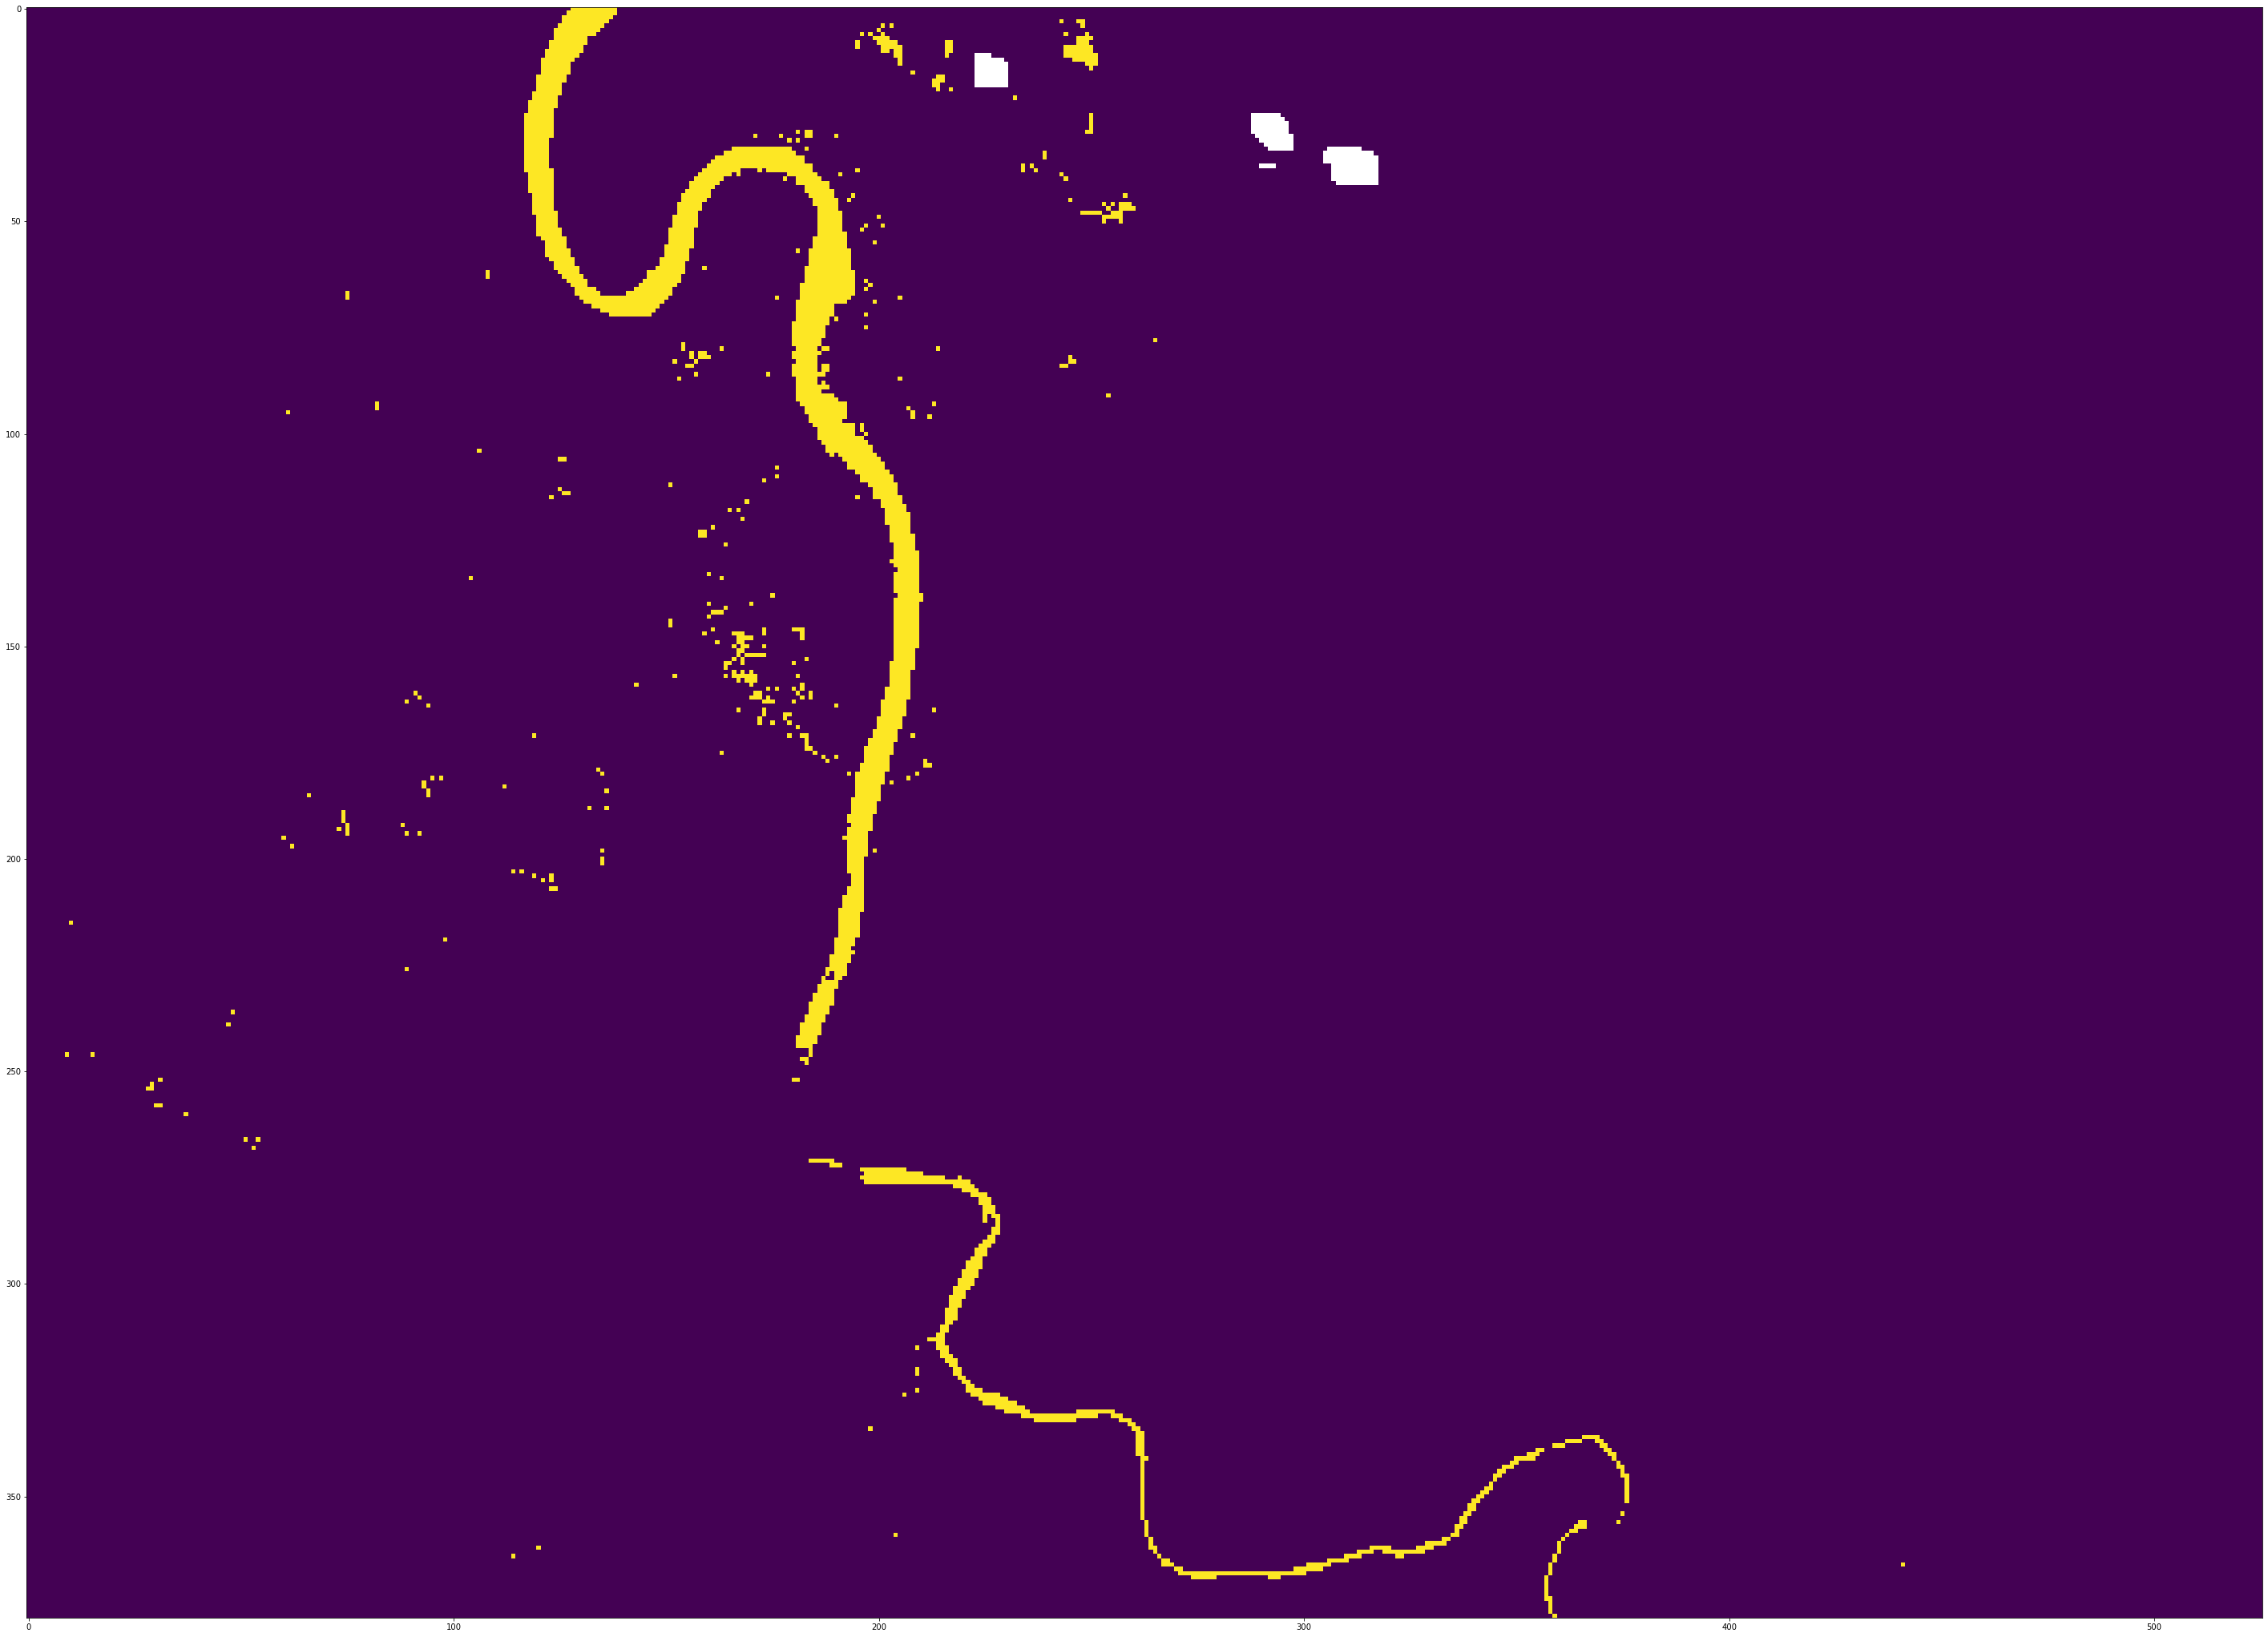

In [72]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_analysis_rc)

In [79]:
diff = (wc_analysis_rc - wc_baseline_rc)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


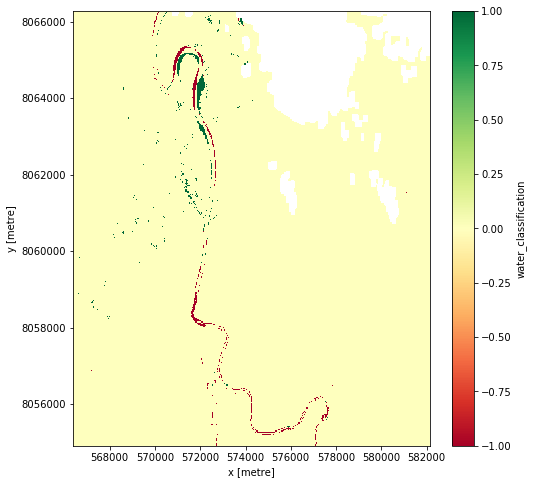

In [81]:
from matplotlib.cm import RdYlGn, Greens
plt.figure(figsize = (8,8))
diff.plot(vmin=-1, vmax=1, cmap=RdYlGn)

## Mask Fractional Cover By Water and Cloud

In [73]:
# mask to removeclouds, cloud shadow, and water. 
frac_cov_masked = wc_baseline_mean.where(wc_baseline_mean.values <= 0.4)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


In [74]:
%%time
frac_cov_masked = frac_cov_masked.compute()

CPU times: user 807 ms, sys: 132 ms, total: 939 ms
Wall time: 1.84 s


/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Create a plot showing FC components.

#Current mask issues in south west corner - with the water mask. 

In [75]:
write_geotiff_from_xr('fractional_cover.tiff', frac_cov_masked, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')

KeyError: 'latitude'

---